<a href="https://colab.research.google.com/github/aquapathos/BasicAI/blob/master/5CNN/CIFAR10PyTorch002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title
# 動作環境の確認
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
if device.type != 'cpu':
  print(torch.cuda.get_device_name())
  print(torch.cuda.get_device_capability())

cpu


# 画像の収集
画像を認識するためには、まず事前にたくさんの事例をAIに機械学習させておく必要がありますが、
大量の画像を自分で用意するのは大変なので、プログラムで収集することにします。

以下、重要な指示は<font color='blue'>青字</font>にしてありますので、見落とさないように演習を進めていってください。

# 1. Google Drive をマウント
Google Colaboratory は一定時間経過すると作業内容が削除されてしまいます。消したくないデータや後日再利用したいデータは Google Drive に保存するようにプログラムすることで、残すことができます。


1. <font color='blue'>この説明の下のセルを実行する
2. アクセス許可の確認ダイアログが出る。「Googleドライブに接続」をクリック。
3. アカウントを選択する。
4. アクセスリクエストのダイアログに変わる。一番下までスクロールし「許可」をクリック。
5. 左のファイル一覧エリアで「更新アイコン」（回転マーク）をクリック（エリアが表示されていないなら「ファイルアイコン」（フォルダ型）をクリック）</font>


<img width="390" alt="googlecolab" src="https://user-images.githubusercontent.com/5820803/94802343-739cff00-0422-11eb-8c0d-affa919f8e58.png">

　<font color=blue>次のセルを実行してください</font>




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. 画像の収集と選別

自分で収集した画像を使って独自のデータセットを作り、先と同様の実験をやってみましょう。

## 2-1 画像の収集

画像を収集するために必要なライブラリを準備します。  <font color='blue'>次のセルを実行してください</font>

In [3]:
#@title
import glob
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
!pip -q install icrawler
# from icrawler.builtin import BingImageCrawler
from icrawler.builtin import GoogleImageCrawler
import warnings
import datetime
warnings.simplefilter('ignore')

ViewSIZE = 128 # 表示用画像サイズ高さと幅
SIZE = 32 # モデルに入力する際の画像サイズ

機械学習の際に画像のサイズをすべて同じに揃えます。ViewSIZEは表示用の画像サイズ、SIZEは学習・認識時のサイズです。  
CIFAR10に合わせるためにSIZE = 32としています。

次に、収集する画像のカテゴリを決めましょう。



--
CIFAR-10 のカテゴリは
- airplane (飛行機)
- automobile (自動車）
- bird (鳥類）
- cat （ネコ)
- deer (シカ）
- dog （イヌ）
- frog （カエル）
- horse（ウマ）
- ship（船舶）
- truck（トラック）

でした。比較したいので、ここに含まれるの中から「ネコ」とネコ以外のカテゴリを１つ、さらに、ここに含まれないカテゴリを２つ考えましょう。
以下では、CIFAR10のカテゴリから「ネコ」と「イヌ」、追加カテゴリとして「カメ」「スクータ」を選んだものとして説明していきます。

下のセルのカテゴリ名と検索用の同義語リストを自分で選んだものに書き換えて実行してください。  
書いてあるものから選んでも構いません。

  <font color='blue'>次のセルを実行してください</font>

In [13]:
synonyms = {'ネコ':['猫','cat'],  # 検索用の同義語を追加
            'イヌ':['犬','dog'],
            'カメ':['亀','turtle'],
            'カエル':['蛙','flog'],
            'サル':['monkey','猿','ゴリラ','メガネザル','チンパンジー'],
            '自転車':['bicycle','シマノ自転車','アサヒ自転車','チャリ'],
            '船舶':['船','ship','ボート','boat','ヨット','クルーザ'],
            '灯台':['lighthouse'],
            '城':['castle','大阪城','姫路城','天守閣'],
            'スクータ':['スクーター','moto scooter','ホンダスクーター','ヤマハスクーター','スズキスクーター'], # 'scooter'だとキックスクータがたくさんでてくる
            'ニワトリ':['rooster', 'hen','レグホン','比内鶏', 'チャボ']
            } # 自分で追加してください。
myclasses = ['ネコ','イヌ','灯台','スクータ']


ネット上で公開されている画像を収集するためのライブラリ、icrawler を使って画像を収集します。 今回は Bing から画像を拾ってくることにします。

次のセルは、上で選んだカテゴリの画像をそれぞれ最大３００枚まで収集して、一旦 Google Drive のマイドライブ内の 'tmp'という名のフォルダに保存するプログラムです。tmpフォルダ内にカテゴリごとのサブフォルダができます。（ "drive/MyDrive" が Google Driveのマイドライブを表しています）

次のセルを実行 　　（５分ぐらいかかります）

In [ ]:
#@title
%%time
max_num = 300 # 収集枚数
TMPFOLDER = 'drive/MyDrive/tmp/' # Google ドライブの マイドライブ内の tmp フォルダ
def collectPictures(folderName = "", keywords = [], max_num = max_num):
    dir = TMPFOLDER+folderName
    os.makedirs(dir, exist_ok=True) # カテゴリごとの画像の保存用フォルダを作成
    crawler = GoogleImageCrawler(storage={"root_dir":dir}, parser_threads=2, downloader_threads=4)
    nomoreimage = False # もう新しい画像が見つからないというフラグ
    picnum = oldpicnum = 0 # 集まった画像数
    year = datetime.datetime.now().year # 収集する画像の登録年
    while picnum < max_num and not nomoreimage and year > 2010:
      for key in keywords:
        filter = dict(size='medium',type='photo',color='color',license='commercial,modify',date=((year, 1, 1),(year, 12, 31)))
        crawler.crawl(keyword=key, filters = filter, max_num=max_num,file_idx_offset='auto')
        if picnum >= max_num:
          break
        picnum = len(glob.glob(dir+"/*")) # ファイル数のカウント
        print(f'({year}) {key} 累積{picnum}枚')
      nomoreimage = (picnum == oldpicnum) # 枚数が増えていない
      year = year - 1
      oldpicnum = picnum

for categ in myclasses:
  # print(categ)
  collectPictures(folderName = categ, keywords = [categ]+synonyms[categ])
  print()

ERRORが出るのはリンク切れ(404)やアクセス制限(403)であり、プログラムのエラーではないので気にしなくても構いません。

## 2-2 画像の選別

![Google Drive](https://raw.githubusercontent.com/aquapathos/pictures/gh-pages/BasicAIFig001.png)　　　　　　 ![Google Drive](https://raw.githubusercontent.com/aquapathos/pictures/gh-pages/BasicAIFig002.png)   

![Google Drive](https://github.com/aquapathos/pictures/blob/gh-pages/BasicAIFig003.png?raw=true)

1. <font color='blue'>ブラウザで新しいタブをつくり、[ドライブ](https://drive.google.com/) を開きます。
2. **マイドライブ**の中の**tmp**フォルダを開いてみてください。 自分が決めたカテゴリのフォルダが並んでいるはずです。
3.「ネコ」を例として説明します。**ネコ** フォルダを開きます。
4. リストレイアウトからグリッドレイアウトに切り替えて不適だと思われる画像を削除してください。
5. 同様にして、ほかのカテゴリ（例ではイヌ、灯台、スクータ）についても不要画像を削除してください。</font>

不適なのは、次のような画像です。
- ネコが写っていない画像。写っていても小さすぎる画像
- 主要被写体がネコではない画像、つまりネコ以外のものが目立っている画像
- 文字が目立つ画像。できれば文字は入っていないことが望ましいですが、目立たなければOK
- デフォルメされたぬいぐるみやイラスト。
- GIF 動画
- 同一の写真

パッと見て、これは「ネコ」が主題の写真だと感じられるものを残して、そうでないもの、他のモノが多くの面積を占めているものは削除してください。(厳密なルールはありません。あなた自身がこれは何かと問われて「ネコ」と答える写真を選べばいいです。あなたの選んだものが教師データとなります。)

# 2-3　画像のリサイズ

何度も使うので関数を定義しておきます。  <font color='blue'>次のセルを実行してください。</font>　　（コードは非表示になっていますが、実行する必要があります。）

In [11]:
#@title リサイズ関数の定義
def resize(foldername, size=ViewSIZE):
    imgnames = glob.glob(foldername+"/*") # 画像ファイル名のリスト
    images = []
    for imgname in imgnames:
        img = cv2.cvtColor(np.array(Image.open(imgname).convert('RGBA')),cv2.COLOR_RGBA2RGB)
        height = img.shape[0]
        width = img.shape[1]
        if height > width :
            m = (height - width)//2
            img = img[m:m+width]
        else:
            m = (width - height)//2
            img = img[:,m:m+height]
        img = cv2.resize(img, (size,size))
        images.append(img)
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        cv2.imwrite(imgname,img)
    return images

さっそくリサイズしてみましょう。　　<font color='blue'>次のセルを実行してください。</font>




In [14]:
# @title
input('不適切画像の削除は終了したら Enterを押してください')
# リサイズを実行
images = []
for i,categ in enumerate(myclasses):
  images.append(resize(TMPFOLDER+categ))
  print(f"{categ} - {len(images[i])} 枚の画像がリサイズされました")
images = np.array(images)

不適切画像の削除は終了したら Enterを押してください
ネコ - 144 枚の画像がリサイズされました
イヌ - 159 枚の画像がリサイズされました
灯台 - 141 枚の画像がリサイズされました
スクータ - 94 枚の画像がリサイズされました


表示用関数を定義し、表示して確認してみます。　　<font color='blue'>次のセルを実行してください。</font>　コードは非表示にしてあります。

In [15]:
#@title 表示用関数の定義
import math
# start番からnpic枚表示する関数を定義
plt.rcParams['figure.figsize'] = (12.0, 7.0)
def showimg(images, start = 0, npic = 48):
    n = npic if len(images) >= start+npic else len(images) - start
    plt.figure(figsize=(8,7.5*(math.ceil(n/8))/6),dpi=150)
    i = 0
    while True:
        if i < n :
            plt.subplot((n-1)//8+1,8,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(images[start+i])
            plt.title("{}".format(start+i))
            i += 1
        else:
            break

さっそく表示させてみましょう。　　<font color='blue'>次のセルを実行してください。</font>

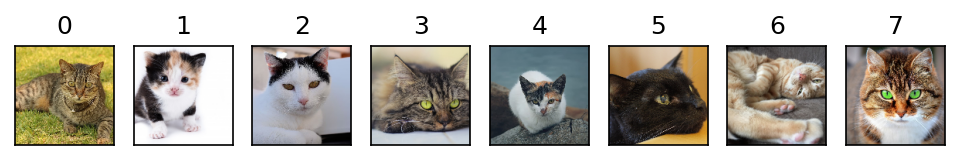

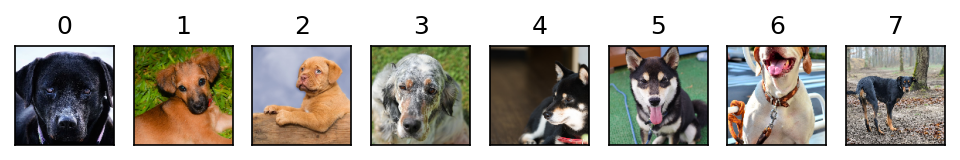

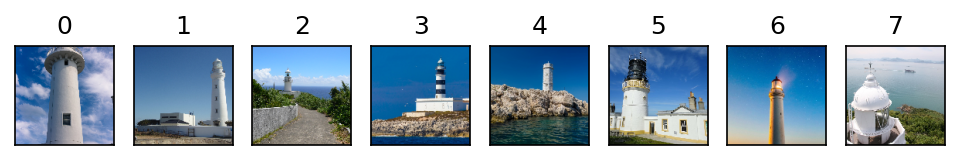

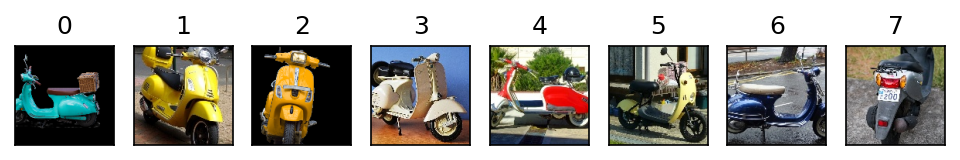

In [16]:
for i in range(len(images)):
  showimg(images = images[i],start=0,npic=8) # 各カテゴリ16枚ずつ表示

## 2-4 学習用画像データの保存と読み込み
python にはメモリ上に置かれた変数の値をそっくりそのままファイルとして保存する関数が用意されていますので、その関数を使って変数の中身を Google ドライブに保存したり、読み出したりできるようにしておきます。　　<font color='blue'>次のセルを実行してください。</font>


In [17]:
#@title
import pickle
import os

# 画像データを pickle 形式で保存
def storeCategoryImages(cat, fname, folder = "."):
    os.makedirs(folder, exist_ok=True)
    f = open(folder+"/"+fname,'wb')
    pickle.dump(cat,f)
    f.close

# pickle 形式で保存された画像データの読み込み
def loadCategoryImages(fname, folder = "."):
    f = open(folder+"/"+fname,'rb')
    cat = pickle.load(f)
    f.close
    return cat

さっそくリサイズした画像をpickle 形式で保存しましょう。　　<font color='blue'>次のセルを実行してください。</font>

In [18]:
GFOLDER = "drive/MyDrive/CIFAR10"  # データ保存用のフォルダ名
for i,categ in enumerate(myclasses):
  print(i,categ)
  storeCategoryImages(images[i],f"{categ}.pkl",folder=GFOLDER)

0 ネコ
1 イヌ
2 灯台
3 スクータ


今度は逆に pickle 形式で保存されたデータを変数に読み込み、正しく復元できるか確認しておきましょう。一つ目のカテゴリだけ試してみます。　　<font color='blue'>次のセルを実行してください。</font>

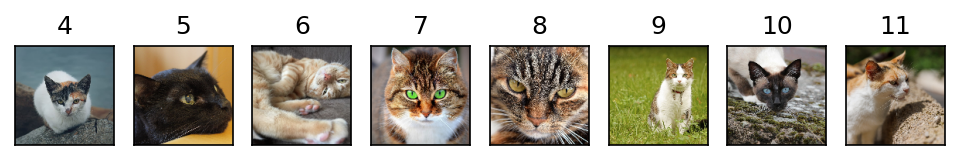

In [19]:
testimg = loadCategoryImages("ネコ.pkl", folder=GFOLDER)
showimg(images = testimg,start = 4,npic=8)

# CIFAR10PyTorch003 に進んでください。

------